<h1>Importing standard stuff</h1>

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use('thomas')
import astropy.units as u
import sys
import scipy.interpolate as interpol
import pandas as pd

<h3>Reading in Harris et al. (http://physwww.mcmaster.ca/~harris/mwgc.dat) files</h3>

In [3]:
gc_general = pd.read_csv('MW_globclus_mod.txt',sep=',')
gc_mv = pd.read_csv('MW_globclus_mv_mod.txt',sep=',')
gc_vel = pd.read_csv('MW_globclus_vel_mod.txt',sep=',')

In [4]:
gc_general[0:3]

,ID,L,B,R_Sun,R_gc,X,Y,Z
0,NGC_104,305.89,-44.89,4.5,7.4,1.9,-2.6,-3.1
1,NGC_288,152.30,-89.38,8.9,12.0,-0.1,0.0,-8.9
2,NGC_362,301.53,-46.25,8.6,9.4,3.1,-5.1,-6.2


In [5]:
gc_mv[0:3]

,m_v,dim
0,3.95,50.0
1,8.09,13.0
2,6.40,14.0


In [6]:
gc_vel[0:3]

,ID,v_r,+/-,v_LSR,sig_v,+/-.1,c,r_c,r_h,mu_V,rho_0,lg(tc),lg(th)
0,NGC_104,-18.0,0.1,-26.7,11.0,0.3,2.07,0.36,3.17,14.38,4.88,7.84,9.55
1,NGC_288,-45.4,0.2,-51.9,2.9,0.3,0.99,1.35,2.23,20.05,1.78,8.99,9.32
2,NGC_362,223.5,0.5,214.0,6.4,0.3,1.76,0.18,0.82,14.80,4.74,7.76,8.93


In [7]:
# changing coordinate system to go from -180 to +180
gl = gc_general['L']
gl[gl > 180] -= 360
gb = gc_general['B']

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# get distance from the Sun
dist = gc_general['R_Sun']

<h3>Plot of GC positions, weighted with distance inverse-squared to see importance</h3>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


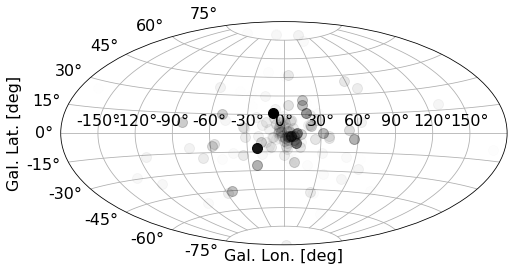

In [10]:
plt.subplot(projection='aitoff')
for i in range(len(gl)):
    plt.plot(np.deg2rad(gl[i]),np.deg2rad(gb[i]),'o',
             alpha=(np.max(dist)/dist[i])**2/np.max((np.max(dist)/dist)**2),color='black',markersize=10)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid('True')
#plt.xlim(-20,20)
#plt.ylim(-20,20)

<h3>And as a function of distance and longitude</h3>

Text(0, 0.5, 'Distance [kpc]')

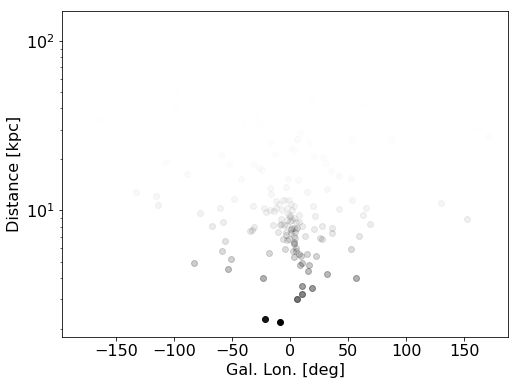

In [12]:
for i in range(len(gl)):
    plt.plot(gl[i],dist[i],'o',alpha=(np.max(dist)/dist[i])**2/np.max((np.max(dist)/dist)**2),color='black')
plt.yscale('log')
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Distance [kpc]')

<h3>Histogram of distances</h3>

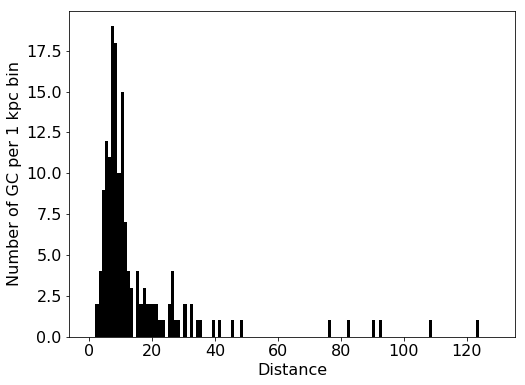

In [13]:
plt.hist(dist,bins=np.arange(130));
plt.xlabel('Distance')
plt.ylabel('Number of GC per 1 kpc bin');

<h3>Estimate masses from half-light radius (r_h) and velocity dispersion (sigma)<br>
    This is pure zero-order kinematics, and is probably flawed.</h3>

In [14]:
sigma = gc_vel['sig_v']
r_h = gc_vel['r_h']

In [15]:
# constants
G      = 6.67408e-11
Msol   = 1.98855e30
kpc2m  = 3.086e19
kms2ms = 1000
M_MW   = 2e10

In [16]:
# choose GCs which have all the information in all tables
good = np.where((sigma != -9999) & (r_h != -9999) & (dist != -9999))[0]
masses = np.full(len(gl),-9999)
masses[good] = 3/2 * (sigma[good]*kms2ms)**2*(dist[good]*np.tan(r_h[good]/60.)*kpc2m) / G / Msol

In [17]:
names = gc_general['ID']

In [18]:
names[np.argmax(masses)]

'NGC_5139'

<h3>NGC5139 is OmegaCen, so at least this works</h3>

<h3>Now as before but also weighted with masses</h3>

In [19]:
mass_dist_ratios = masses*(np.max(dist)/dist)**2 / np.max(masses*(np.max(dist)/dist)**2)

In [20]:
np.median(mass_dist_ratios[good])

0.013238064136918429

In [21]:
# to fill the unknown mass-to-light ratios, I use the median of the ones that I have to estimate a total contribution
mass_dist_ratios_fill = np.copy(mass_dist_ratios)
bad = np.where(mass_dist_ratios_fill < 0)[0]
mass_dist_ratios_fill[bad] = np.median(mass_dist_ratios[good])+np.abs(np.random.randn(len(bad))*np.median(mass_dist_ratios[good])*1)

Text(0, 0.5, '"Flux" contribution with increasing number of GCs')

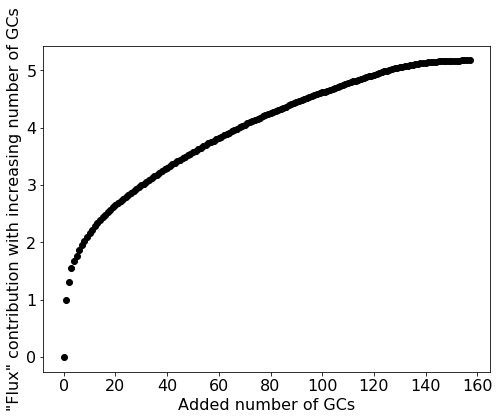

In [23]:
plt.plot(np.concatenate([np.array([0]),np.cumsum(np.flip(np.sort(mass_dist_ratios_fill)))]),'o')
plt.xlabel('Added number of GCs')
plt.ylabel('"Flux" contribution with increasing number of GCs')

<h3>The jump from 0 to 1 indicates OmegaCen (as normalised to 1), adding all other GCs adds less (if weighted with mass/distance^2), but in total accounts to about 5 times of OmegaCen only. Good.</h3>

<h3>Now using the values from Baumgardt et al. (2018) because they provide most of the information we need</h3>

In [24]:
gc_baumgardt = pd.read_csv('MW_globclus_Baumgardt2018_combined_table_mod.txt',sep=',')

In [25]:
gc_baumgardt[0:3]

,Cluster,RA,DEC,R_Sun,R_GC,Mass,Mass_err,V,V_err,(M/L_V),...,rho_hm,sig_c,sig_hm,lgTrh,MF,F_REM,sig0,vesc,etac,etah
0,NGC_104,6.02363,-72.08128,4.43,7.78,761000.0,5030.0,4.07,0.11,1.72,...,2.76,4.94,3.69,9.54,-0.47,0.52,12.2,49.7,-0.40,-0.04
1,NGC_288,13.18850,-26.58261,9.98,13.17,121000.0,3490.0,8.16,0.07,2.40,...,1.20,2.68,2.43,9.59,-0.44,0.68,3.3,11.1,-0.17,-0.09
2,NGC_362,15.80942,-70.84878,9.17,10.00,333000.0,4880.0,6.55,0.16,1.67,...,2.77,4.71,3.58,9.28,-0.88,0.49,8.8,31.7,-0.27,-0.09


<h3>To cross-validate indices and names, I calculate the galactic longitude and latitude from the given ra and dec values, and match them as needed ...</h3>

In [26]:
ra = gc_baumgardt['RA']
dec = gc_baumgardt['DEC']

Text(0, 0.5, 'DEC [deg]')

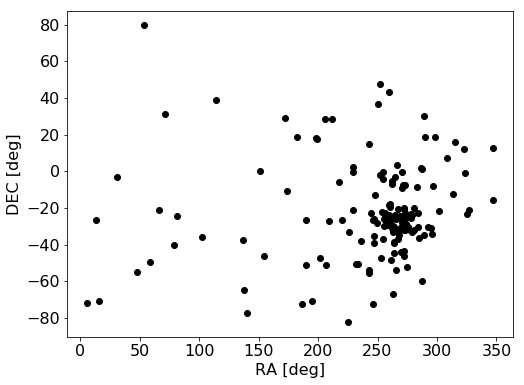

In [30]:
plt.plot(ra,dec,'o')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [31]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [32]:
i = 0
c_arr = []
for i in range(len(ra)):
    c = SkyCoord(ra=ra[i],
                 dec=dec[i], unit=(u.degree, u.degree))
    c_arr.append([c.galactic.l.deg,c.galactic.b.deg])
c_arr = np.array(c_arr)

In [33]:
c_arr.shape

(154, 2)

In [34]:
gl2 = c_arr[:,0]
gl2[gl2 > 180] -= 360
gb2 = c_arr[:,1]

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


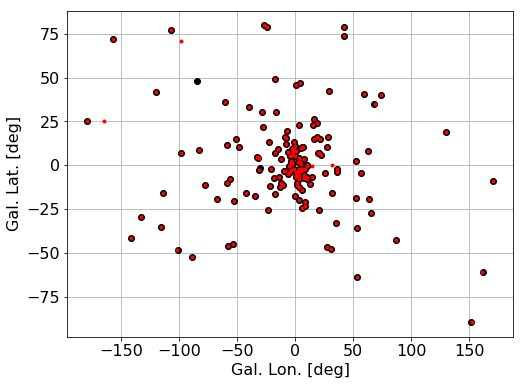

In [36]:
plt.plot(gl2,gb2,'o')
plt.plot(gl,gb,'r.')
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid('True')

<h3>Most of the GCs are the same, a few (lt 5) are missing, and a few others (lt 5) are added, so not mch difference</h3)

<h3>Now getting the masses from Baumgardt and doing the same excercise</h3>

In [37]:
masses2 = gc_baumgardt['Mass']
masses2_err = gc_baumgardt['Mass_err']

In [38]:
dist2 = gc_baumgardt['R_Sun']

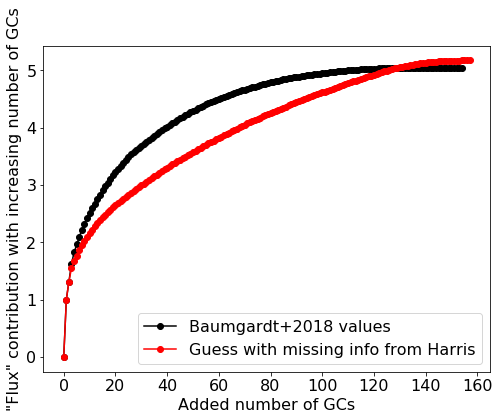

In [45]:
plt.plot(np.concatenate([np.array([0]),np.cumsum(np.flip(np.sort(masses2*(np.max(dist2)/dist2)**2/np.max(masses2*(np.max(dist2)/dist2)**2))))]),'o-',label='Baumgardt+2018 values')
plt.plot(np.concatenate([np.array([0]),np.cumsum(np.flip(np.sort(mass_dist_ratios_fill)))]),'ro-',label='Guess with missing info from Harris')
plt.xlabel('Added number of GCs')
plt.ylabel('"Flux" contribution with increasing number of GCs')
plt.legend()

<h3>Basically the same absolute result (the path is not too important here, right now), good</h3>

<h3>Now what about mass to light ratios:</h3>

In [46]:
m2l2 = gc_baumgardt['(M/L_V)']
m2l2_err = gc_baumgardt['(M/L_V)_err']

Text(0, 0.5, 'Number of GCs per $0.1\\,\\mathrm{M_{\\odot}/L_{\\odot}}$ bin')

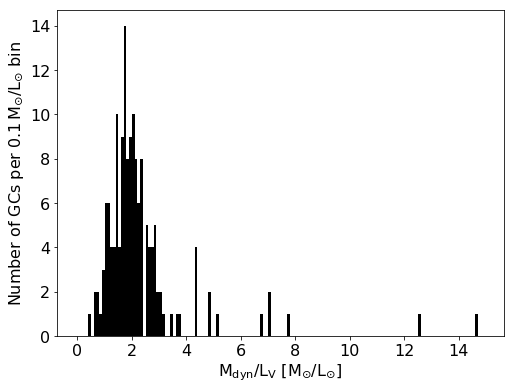

In [49]:
plt.hist(m2l2,bins=np.arange(0,15,0.1));
plt.xlabel(r'$\mathrm{M_{dyn}/L_V}$ [$\mathrm{M_{\odot}/L_{\odot}}$]')
plt.ylabel('Number of GCs per $0.1\,\mathrm{M_{\odot}/L_{\odot}}$ bin')

<h3>As described in the paper you showed me about NGC21..., most of the GCs show a M/L around 2, apparently compatibel with no dark matter. Somewhat smaller and larger values are probably also compatible with no dark matter. However, values above 5(?) or more seem to have some DM contributions, I guess.</h3>

<h3>From the assumption:<br>
    Mstar/L_V = 1<br>
    I calculate the stellar (and dark matter) mass for each GC as a zero-order estimate (this may change later).</h3>

In [50]:
Vmag = gc_baumgardt['V']

In [52]:
# absolute V-band magnitude of the Sun
Vsun = 4.83

In [53]:
Vmag_abs = Vmag - 5*np.log10(dist2*1e2)

<h3>The V-band luminosty of each GC is calculated as the total mass versus the mass-to-light ratio<h3>

In [54]:
L_V2 = masses2/m2l2

In [56]:
Mstar = masses2-(m2l2-1)*L_V2 # this means Mstar == L_V2, just in other units (as Mstar/L_V = 1)
Mstar_err = L_V2*np.sqrt((masses2_err/masses2)**2 + (m2l2_err/m2l2)**2)

<h3>Appearance as a function of stellar mass (OmegaCen the brightest again)</h3>

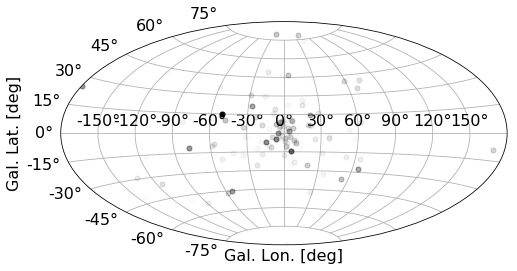

In [67]:
plt.subplot(projection='aitoff')
for i in range(len(gl2)):
    plt.plot(np.deg2rad(gl2[i]),np.deg2rad(gb2[i]),'o',
             alpha=(Mstar[i])**(1)/np.max((Mstar)**(1)),color='black',markersize=5)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid('True')
#plt.xlim(-20,20)
#plt.ylim(-20,20)

In [68]:
M_DM = masses2 - Mstar
M_DM[M_DM < 0] = 0

<h3>Now reading in your file with the GeV fluxes (I modified it to have comma separators)</h3>

In [70]:
gc_GeV = pd.read_csv('MWGCgamma_mod.txt',sep=',')

In [71]:
gc_GeV[0:3]

,Name,distance[kpc],log(Lgamma[erg/s]),errup,errdown,l,b,IBISobs[ksec],SPIobs[ksec],3sigmaUL[ph/cm2/s]
0,47Tuc,4.0,34.68,0.12,0.13,305.8953,-44.8891,4995.8,3688.4,0.00000
1,OmegaCen,4.8,34.44,0.13,0.15,309.1020,14.9683,4704.4,4018.6,0.00017
2,M62,6.6,35.04,0.12,0.14,353.5746,7.3196,19675.1,19337.6,0.00000


In [72]:
names_GeV = gc_GeV['Name']
gl_GeV = gc_GeV['l']
gl_GeV[gl_GeV > 180] -= 360
gb_GeV = gc_GeV['b']

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<h3>I match the GCs in the two files (Baumgardt and yours) by the longitude and latitude values to get the indices of the GCs in the larger file</h3>

In [73]:
idx_GeV = []
for i in range(len(gl_GeV)):
    idx_GeV.append(np.where((np.round(gl2,1) == np.round(gl_GeV[i],1)) & 
                            (np.round(gb2,1) == np.round(gb_GeV[i],1)))[0])
idx_GeV = np.array(idx_GeV)
idx_GeV = idx_GeV.reshape(len(gl_GeV))

In [74]:
idx_GeV

array([  0,  27,  61,  85,  92,  93, 121, 125,  81,  45,  94, 120, 109,
       134,  38, 148,  88,  55,  49])

<h3>and for some reason I go back to absolute values, not logarithmic (though, I go back later)</h3>

In [75]:
lgL_GeV = gc_GeV['log(Lgamma[erg/s])']
lgL_GeV_errlo = gc_GeV['errdown']
lgL_GeV_errup = gc_GeV['errup']
L_GeV = 10**lgL_GeV

In [76]:
L_GeV_err = (10**(lgL_GeV+lgL_GeV_errup)-10**(lgL_GeV-lgL_GeV_errlo))/2

<h3>Reading off ther values from the Bartels paper</h3>

In [77]:
# from 1711.04778
Mstar_NB = 1.4e9
Mstar_NB_err = 0.6e9
Mstar_BB = 0.91e10
Mstar_BB_err = 0.7e10

Mstar_disk = 5e10
Mstar_disk_err = 0.5e10

Mstar_M31 = 5.5e10
Mstar_M31_err = 1.1e10

# reading off:
L_GeV_NB = 2e36
lgL_GeV_NB = np.log10(L_GeV_NB)
L_GeV_NB_err = 0.5e36

L_GeV_BB = 2e37
L_GeV_BB_err = 0.05*L_GeV_BB
lgL_GeV_BB = np.log10(L_GeV_BB)

L_GeV_disk_min = 0.5e37
L_GeV_disk_max = 15e37
L_GeV_disk = (L_GeV_disk_max+L_GeV_disk_min)/2
L_GeV_disk_err = (L_GeV_disk_max-L_GeV_disk_min)/2

L_GeV_M31 = 6.6e38
L_GeV_M31_err = 0.6/5.6*L_GeV_M31

<h3>This should be the value for M31, but I am not sure, if this is completely correct, but anyway can be changed easily</h3>

In [79]:
(5.6e-12*u.erg/u.s/u.cm**2*(785*u.kpc)**2).to(u.erg/u.s)*20 #?

<Quantity 6.57140792e+38 erg / s>

In [80]:
mm = np.logspace(3,12,1000)
Bartels2018 = 2e27*mm

<h3>Overview plot of the values that we have now, together with your linear function derived from the NB and BBM</h3>

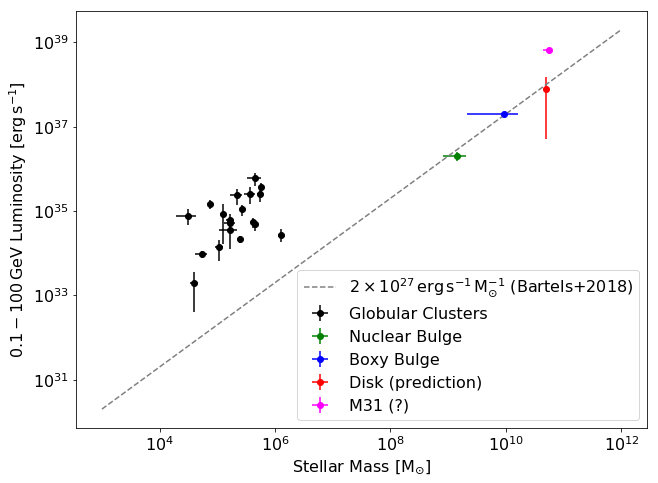

In [82]:
fig,ax = plt.subplots(figsize=(10.24,7.68))

ax.errorbar(Mstar[idx_GeV],L_GeV,xerr=Mstar_err[idx_GeV],yerr=L_GeV_err,fmt='o',label='Globular Clusters')
ax.errorbar(Mstar_NB,L_GeV_NB,xerr=Mstar_NB_err,yerr=L_GeV_NB_err,fmt='go',label='Nuclear Bulge')
ax.errorbar(Mstar_BB,L_GeV_BB,xerr=Mstar_BB_err,yerr=L_GeV_BB_err,fmt='bo',label='Boxy Bulge')
ax.errorbar(Mstar_disk,L_GeV_disk,xerr=Mstar_disk_err,yerr=L_GeV_disk_err,fmt='ro',label='Disk (prediction)')
ax.errorbar(Mstar_M31,L_GeV_M31,xerr=Mstar_M31_err,yerr=L_GeV_M31_err,color='magenta',fmt='o',label='M31 (?)')

ax.plot(mm,Bartels2018,color='gray',linestyle='--',
         label=r'$\mathrm{2 \times 10^{27}\,erg\,s^{-1}\,M_{\odot}^{-1}}$ (Bartels+2018)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
ax.set_ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

ax.legend(loc=4)

<h3>Now, I make one array out of it and perform some fits with a power-law:<br>
    1) scipy.curve_fit (plain chi2)<br>
    2) emcee (with priors)<br>
    3) stan (with priors and uncertainties in both directions)<br>
    4) stan (everything together, accounting for the miss-match between data and model, determining a systematic uncertainty<h3>

In [83]:
masses_all = np.concatenate([Mstar[idx_GeV].values,np.array([Mstar_NB]),np.array([Mstar_BB])])
masses_all_err = np.concatenate([Mstar_err[idx_GeV].values,np.array([Mstar_NB_err]),np.array([Mstar_BB_err])])

L_GeV_all = np.concatenate([L_GeV.values,np.array([L_GeV_NB]),np.array([L_GeV_BB])])
L_GeV_all_err = np.concatenate([L_GeV_err.values,np.array([L_GeV_NB_err]),np.array([L_GeV_BB_err])])

<h3>Step 1) curve_fit</h3>

In [84]:
from scipy.optimize import curve_fit

In [85]:
def powerlaw_correlation(x,lgN,alpha):
    return 10**lgN*x**alpha

In [86]:
fit_p, fit_cov = curve_fit(powerlaw_correlation,masses_all,L_GeV_all,p0=[27,1],sigma=L_GeV_all_err)

In [87]:
fit_e = np.sqrt(np.diag(fit_cov))

<h3>Fitted parameters and uncertainties from curve_fit:</h3>

In [89]:
print('(lgNorm, alpha) = ',fit_p)
print('(lgNorm_err,alpha_err) = ',fit_e)

(lgNorm, alpha) =  [30.65479986  0.66048687]
(lgNorm_err,alpha_err) =  [0.31796751 0.03451236]


<h3>That is somewhat less steep than your correlation, and at another normalisation (as the GCs are somewhat higher and "to the left"</h3>

<h3>Step 2) emcee</h3>

In [90]:
import emcee

# Define the posterior
# Reminder: posterior(model parameters, data) = likelihood(data, model parameters) * prior(model parameters)
# emcee uses logarithmic probability distributions

# As prior, we assume normal distributions (may change later)
def lnprior(theta):
    lgN, alpha = theta
    mu_lgN = 30.6 # just the values from before
    sigma_lgN = 0.3
    mu_alpha = 0.66
    sigma_alpha = 0.03
    return -0.5*(lgN-mu_lgN)**2/sigma_lgN**2 -0.5*(alpha-mu_alpha)**2/sigma_alpha**2

# As likelihood, we assume the normal distribution (gaussian uncertainties on extracted parameters)
def lnlike(theta, x, y, yerr):
    lgN, alpha = theta
    model = powerlaw_correlation(x,lgN,alpha)
    return -0.5*(np.sum( ((y-model)/yerr)**2 ))

# full posterior
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [91]:
import scipy.optimize as op

In [92]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, (30.6, 0.3), args=(masses_all, L_GeV_all, L_GeV_all_err),)
N_ml, alpha_ml = result.x

<h3>Again, using the maximum likelihood solution as initial guess for the emcee sampler</h3>

In [94]:
result

      fun: 72.48405260400959
 hess_inv: array([[ 0.01583411, -0.0017011 ],
       [-0.0017011 ,  0.00018757]])
      jac: array([9.53674316e-07, 2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 7
     njev: 17
   status: 0
  success: True
        x: array([30.65481882,  0.66048478])

In [95]:
ndim, nwalkers = 2, 10
pos = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(masses_all, L_GeV_all, L_GeV_all_err))

In [96]:
from tqdm import tqdm_notebook as tqdm

In [97]:
_ = sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:01<00:00, 1756.49it/s]


In [98]:
samples = sampler.flatchain
samples.shape

(20000, 2)

In [99]:
import corner

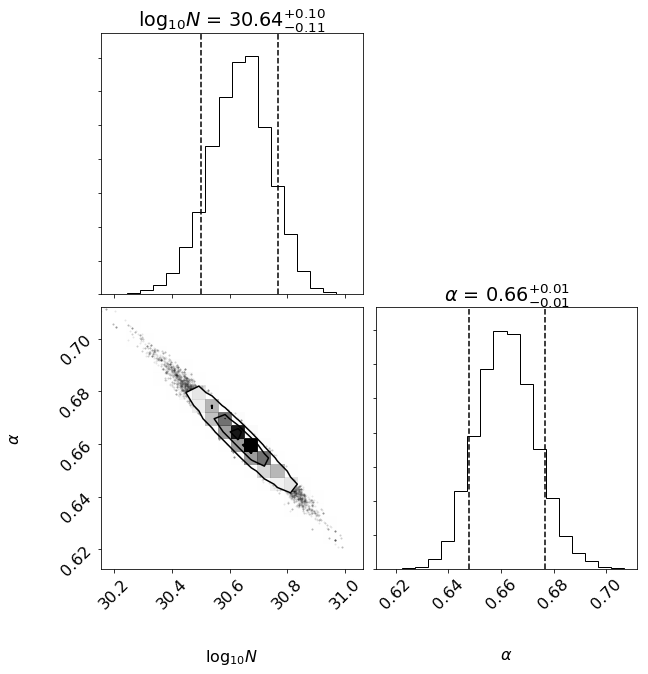

In [101]:
#let's plot the results
fig = corner.corner(samples, labels=[r'$\log_{10}N$',r'$\alpha$'],
                    #range=((0.5e35,1.5e35),(0.7,0.8)),
                    quantiles=[0.1,0.9],show_titles=True)
fig.set_size_inches(10,10)

<h3>Parameters look good, let's see how the model performs (probably bad because the model is not capturing all the points)</h3>

In [102]:
# evaluate models according to posterior sampling
N_model = len(mm)

y_models = np.zeros((N_model,samples.shape[0]))
for i in range(samples.shape[0]):
    y_models[:,i] = powerlaw_correlation(mm,samples[i,0],samples[i,1])

Text(0, 0.5, '$0.1-100\\,\\mathrm{GeV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

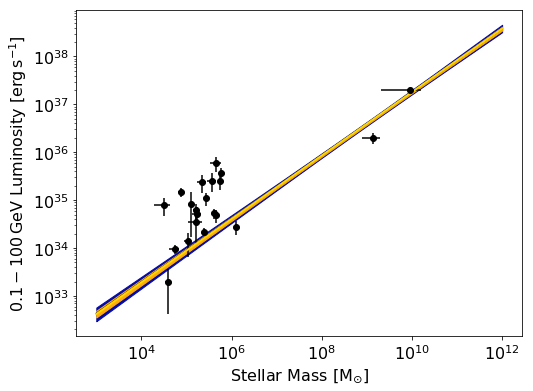

In [151]:
plt.errorbar(masses_all,L_GeV_all,xerr=masses_all_err,yerr=L_GeV_all_err,fmt='ko',label='measured values')
plt.plot(mm,powerlaw_correlation(mm,*fit_p))

level = 95.4
plt.fill_between(mm,
                np.percentile(y_models, 50 - 0.5*level, axis=1 ),
                np.percentile(y_models, 50 + 0.5*level, axis=1 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Model (95th)')

level = 68.3
plt.fill_between(mm,
                np.percentile(y_models, 50 - 0.5*level, axis=1 ),
                np.percentile(y_models, 50 + 0.5*level, axis=1 ),
                color='xkcd:yellowish orange',alpha=1,label='Model (68th)')

fit_model = np.median(y_models,axis=1)
plt.plot(mm,fit_model,linewidth=2,color='gold',label='Median model')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

<h3>Basically same result (as expected), and we see that many points are just "above" the line, which we will take into account in step 4), now step 3), stan:</h3>

In [105]:
import stan_utility
import pystan
import pickle

<h3>First, let's generate some data that should follow a powerlaw model that we put into, however with error bars in both directions<h3>

In [106]:
model_pl_gen = stan_utility.compile_model('generate_powerlaw_xy.stan')

Using cached StanModel


<h3>Here we define our fake data set to be sure that the other things (real data) will work in the end:</h3>

In [107]:
N = 20 # number of observations to predict
lgNorm = 30.6 # as before
alpha = 0.7 # as before
sigma_x_percent = 0.1 + np.random.rand(N)*0.3 # the uncertainty of the masses in percentl, drawn from a uniform distribution between 10 and 40 %
sigma_y_percent = 0.05 + np.random.rand(N)*0.15 # same for the fluxes, but between 5 and 20%
lgx_min = 3 # minimum value to be draw for the masses 10^3
lgx_max = 10 # maximum 10^10

data_gen = dict(N = N,
                lgNorm = lgNorm,
                alpha = alpha,
                sigma_x_percent = sigma_x_percent,
                sigma_y_percent = sigma_y_percent,
                lgx_min = lgx_min,
                lgx_max = lgx_max)

gen = model_pl_gen.sampling(data=data_gen,seed=123456, algorithm='Fixed_param', iter=1, chains=1)

In [108]:
x_obs = gen['x_obs'].reshape(N)
x_latent = gen['x_latent'].reshape(N)
y_obs = gen['y_obs'].reshape(N)
y_latent = gen['y_latent'].reshape(N)

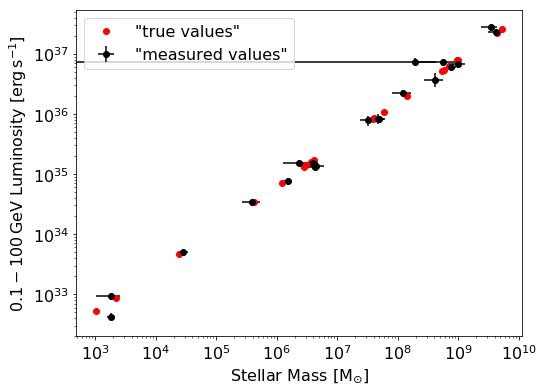

In [112]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x_percent*x_latent,yerr=sigma_y_percent*y_latent,fmt='ko',label='"measured values"')
plt.loglog(x_latent,y_latent,'ro',label='"true values"')
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')
plt.legend()

<h3>The red values are draw from the generative model, and the obscured to appear "as measured" (black points with "error bars")</h3>

<h3>In general, this would be much more scattered and a cloud of points somewhere (the GCs), this will be included later</h3>

In [114]:
# where to evaluate the model for posterior prediction
N_model = 100
x_model = np.logspace(2,11,N_model)

In [115]:
# dictionary for test data set and prior
data_test = dict(N = N,
            x_obs = x_obs,
            y_obs = y_obs,
            sigma_x = sigma_x_percent*x_latent,
            sigma_y = sigma_y_percent*y_latent,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 30,
            sigma_lgNorm = 1,
            mu_alpha = 1,
            sigma_alpha = 0.3)

In [116]:
"""## compile model (if not yet compiled):
model_pl = pystan.StanModel('fit_powerlaw_xy.stan')

## save it to the file 'filename.pkl' for later use
with open('fit_powerlaw_xy.pkl', 'wb') as f:
    pickle.dump(model_pl, f)"""
    
#read filename.pkl (if already compiled)
model_pl = pickle.load(open('fit_powerlaw_xy.pkl', 'rb'))

In [117]:
init = {}
init['lgNorm'] = 30.
init['alpha'] = 1.
init['lgx_latent'] = np.log10(x_obs)
op = model_pl.optimizing(data=data_test,as_vector=False,init=init)

In [118]:
print('(lgNorm, alpha) = ',op['par']['lgNorm'],op['par']['alpha'])

(lgNorm, alpha) =  30.39528281145396 0.7249756726335043


<h3>Now full sampling to get the distributions of lgNorm and alpha:</h3>

In [121]:
yfit = op['par']['powerlaw']

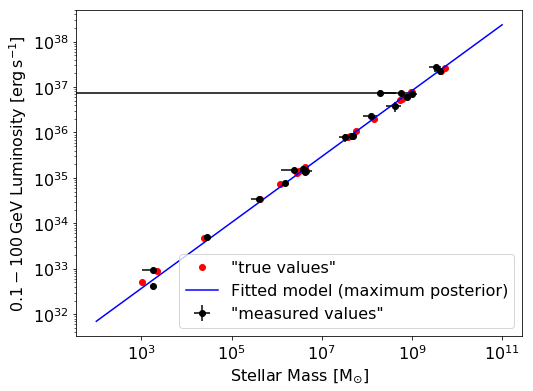

In [123]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x_percent*x_latent,yerr=sigma_y_percent*y_latent,fmt='ko',label='"measured values"')
plt.loglog(x_latent,y_latent,'ro',label='"true values"')
plt.loglog(x_model,yfit,label='Fitted model (maximum posterior)',color='blue')
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')
plt.legend()


In [124]:

# fit the model
fit_pl_test = model_pl.sampling(data=data_test,verbose=True,chains=4,iter=2000,algorithm='HMC')

In [125]:
print(fit_pl_test.stansummary(['lgNorm','alpha']))

Inference for Stan model: anon_model_4b3db346f8e8f36212ed3cf0b239486f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm  30.41  2.1e-3   0.09  30.23  30.35  30.41  30.47  30.58   1824    1.0
alpha    0.72  3.1e-4   0.01    0.7   0.71   0.72   0.73   0.75   1481    1.0

Samples were drawn using HMC at Thu Nov  7 17:31:24 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h3>Let's check how this looks like, again</h3>

In [126]:
chain = fit_pl_test.extract()

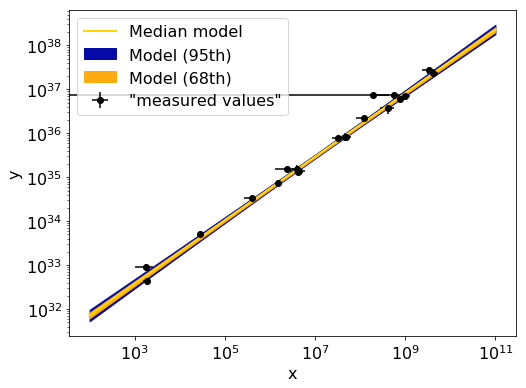

In [127]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x_percent*x_latent,
             yerr=sigma_y_percent*y_latent,fmt='ko',label='"measured values"')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='Model (68th)')

fit_model = np.median(chain['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='Median model')
    
plt.xlabel('x')
plt.ylabel('y')

plt.xscale('log')
plt.yscale('log')

plt.legend()

#plt.plot(x_model,10**lgNorm*(x_model/1e7)**alpha,color='cyan',linewidth=4)

<h3>In particular, this model fits for the "correct position" of the the data points, i.e. where the true values would be, according to the model, and according to the uncertainties in x and y (not yet accounting for "systematic effects"):</h3>

In [145]:
colors = plt.cm.jet(y_obs/np.mean(y_obs))

Text(0, 0.5, 'y')

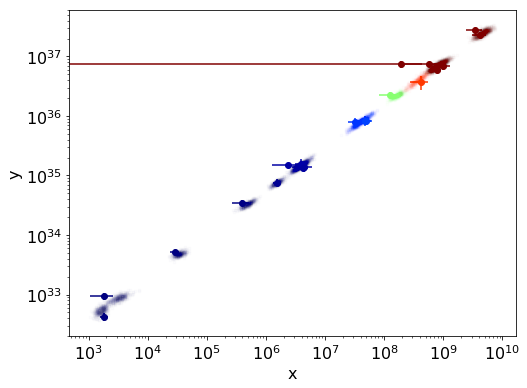

In [147]:
for i in range(N):
    plt.loglog(10**chain['lgx_latent'][::10,i],10**chain['lgy_true'][::10,i],'.',alpha=0.01,color=colors[i])
    plt.errorbar(x_obs[i],y_obs[i],yerr=sigma_y_percent[i]*y_latent[i],xerr=sigma_x_percent[i]*x_latent[i],fmt='o',color=colors[i])
plt.xlabel('x')
plt.ylabel('y')

<h3>Each point of clouds is basically the posterior prediction of the data points. As is in this case, the measured points and the predicted posteriors coincide. In the data case (see below), this is not true any more and we will need a parameter (or two) to describe the "systematics".</h3>

<h3>Now a run for the real data</h3>

In [148]:
# where to evaluate the model for posterior prediction
N_model = 100
x_model = np.logspace(2,11,N_model)

In [149]:
N_obs = len(masses_all)

# dictionary for data set and prior
data = dict(N = N_obs,
            x_obs = masses_all,
            y_obs = L_GeV_all,
            sigma_x = masses_all_err,
            sigma_y = L_GeV_all_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 30,
            sigma_lgNorm = 1,
            mu_alpha = 0.7,
            sigma_alpha = 0.1)

In [150]:
# fit the model
fit_pl = model_pl.sampling(data=data,verbose=True,chains=4,iter=2000,algorithm='HMC')

In [152]:
print(fit_pl.stansummary(['lgNorm','alpha']))

Inference for Stan model: anon_model_4b3db346f8e8f36212ed3cf0b239486f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm  33.53    1.89   2.67  31.65  31.92  32.08  35.39   38.4      2  15.39
alpha    0.25    0.34   0.48  -0.62  -0.08   0.51   0.53   0.58      2  15.27

Samples were drawn using HMC at Thu Nov  7 17:46:16 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [153]:
chain = fit_pl.extract()

Text(0, 0.5, '$0.1-100\\,\\mathrm{GeV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

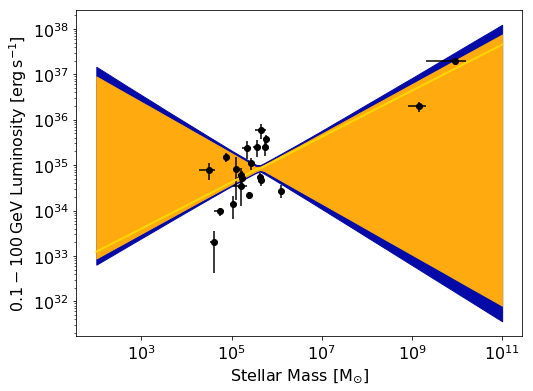

In [154]:
# make some plots of interest

#plt.loglog(x_obs,y_obs,'ko')
plt.errorbar(masses_all,L_GeV_all,xerr=masses_all_err,yerr=L_GeV_all_err,fmt='ko')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0)

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1)

fit_model = np.median(chain['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold')
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

#plt.plot(x_model,10**lgNorm*(x_model/1e7)**alpha,color='cyan',linewidth=4)

<h3>Clearly, the model is ... bad, and we need to include a parameter which describes this, typically introduced as "systematic uncertainty", which however, is quantifiable given the values we have. We will cahnge the model and also fit for this parameterm, either as varying the same way in x and y, or independently. The latter might be more reasonable since the flux measurements are in general less affected by modelling.</h3>

<h3>Step 4) a full model</h3>